This notebook will be a perform a quick inspection of the predictive powers of several classification models.  
A multiclass classification of the constucted author ranks will be the objective.  
Recall that the ranks divide the authors into 3 groups, based on the total number of upvotes their articles received.  
The 'top' class of authors have the most and account for 25% of the total up votes.  
Similarly, the 'bottom' class of authors have the least up votes and are responsible for another 25% .  
The 'middle' class is just that and holds the remaining half of the up votes.  
An very important factor in this modeling is the choice of the proper performance metric to monitor.  
Since I would like the model to correctly find the 'top' authors, and their numbers are small, the recall metric is needed.  
The recall is the percentage of authors that were predicted as being in the 'top' class that were corectly predicted.  
I am more interested in finding the greatest number of rare authors, than identifying authors who are not generating traffic.  
Term Frequency-Inverse Document Frequency (TF-IDF) values will be genrated for each author from their article tokens.  
These will be used to train the various models through a custom built 10 fold cross validation function.  
Classification reports and confusion matrices will be averaged over all folds for each model to find the best one.  
The desired performance metric will be plotted for each fold, across all models.  
Once the best model as been selected, the data will be exported to optimize its hyperparameters in another notebook.

In [1]:
# set cell display width
from IPython.display import display, HTML, display_html
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
#from pickle import dump as pkl_dump, load as pkl_load
#from joblib import Parallel, delayed, dump, load

In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# silence 'invalid metric' warning during call to confusion_matrix
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
# silence future warning
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "my_big_pallette.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


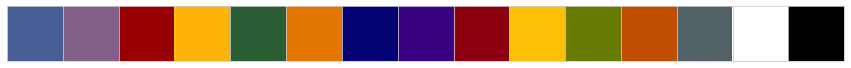

In [5]:
# import and set custom palette module
import my_big_palette as mp
sns.set_palette(sns.color_palette(mp.my_palette))

In [6]:
# free autocomplete from Jedi mind control
%config Completer.use_jedi = False

> **IMPORT DATA**

First, I'll read in the author version of the data, grabbing only the index, rank feature, and full titles for reference.

In [7]:
# read in dataset and observe current form of data
df = pd.read_csv('../data/author_data.csv', index_col='author', 
                 usecols=['author', 'rank', 'titles'])
df

,rank,titles
author,,
maxwellhill,top,['Chinese Premier accuses Dalai Lama of master...
anutensil,top,"['Top 10 discoveries of 2009', 'Mystery behind..."
Libertatea,top,['Life inside the Ecuadorian embassy with Wiki...
DoremusJessup,top,['Human Rights Watch claims $32 billion missin...
Wagamaga,top,['The government wants penalties including pot...
...,...,...
davitruiz,bottom,['Madrid train strike the day before holiday w...
davie18,bottom,['Remember that letter to Sainsbury s where a ...
davidstern350,bottom,['UOSSM Urges the International Organizations ...


Next, I'll import the tokens that were generated from the titles during topic modeling from a previous notebook.

In [8]:
# read in extracted tokens generated from titles
df['tokens'] = pd.read_csv('../data/author_tokens.csv', index_col='author', 
                 usecols=['author', 'tokens'], converters={'tokens': eval})
df['tokens']

author
maxwellhill      [chinese, premier, accuse, dalai, lama, master...
anutensil        [discovery, mystery, make, stradivarius, speci...
Libertatea       [life, inside, ecuadorian, embassy, wikileaks,...
DoremusJessup    [human, rights, watch, claim, billion, miss, a...
Wagamaga         [government, want, penalty, include, potential...
                                       ...                        
davitruiz        [madrid, train, strike, day, holiday, weekend,...
davie18          [remember, letter, sainsbury, little, girl, sa...
davidstern350    [uossm, urges, international, organizations, e...
davidmj85                  [nsw, bushfires, live, update, october]
zzzcott          [headless, corpse, find, pile, highway, northe...
Name: tokens, Length: 85838, dtype: object

The Pandas method used to save the tokens converted all of the lists to string format.  
I'll fix this with a quick function.

In [9]:
def list_to_string(data):
    """Returns long string from list of strings"""
    long_string = ' '.join(data)
    
    return long_string

In [10]:
# combine tokens into long document strings
df['docs'] = df['tokens'].apply(list_to_string)
df['docs']

author
maxwellhill      chinese premier accuse dalai lama mastermind r...
anutensil        discovery mystery make stradivarius special co...
Libertatea       life inside ecuadorian embassy wikileaks found...
DoremusJessup    human rights watch claim billion miss angola a...
Wagamaga         government want penalty include potential jail...
                                       ...                        
davitruiz        madrid train strike day holiday weekend ley mo...
davie18          remember letter sainsbury little girl say tige...
davidstern350    uossm urges international organizations extend...
davidmj85                        nsw bushfires live update october
zzzcott          headless corpse find pile highway northern mexico
Name: docs, Length: 85838, dtype: object

Now, I'll generate the TF-IDF values to be used by the classification model.

In [11]:
# instantiate Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer
vectorizer = TfidfVectorizer()

In [12]:
# compute word count, IDF, and TF-IDF values
tf_idf_vectors = vectorizer.fit_transform(df['docs'])

I'll inspect a portion of the vector representing the titles from the first author.

In [13]:
# display top 8 TF-IDF scores for first author
pd.DataFrame(tf_idf_vectors[0].T.todense(), 
             index=vectorizer.get_feature_names(), 
             columns=['1st_doc_tf-idf']).sort_values(
    '1st_doc_tf-idf', ascending=False)[:8]

,1st_doc_tf-idf
say,0.155776
law,0.138520
police,0.131821
drug,0.131208
new,0.129258
country,0.129078
government,0.123537
world,0.116818


This will be the feature data used to train the models.

> **MODEL SELECTION**

This classification aims to identify the authors whose choice of articles received an imbalanced proportion of up votes.  
Isolating those authors and identifying why they got such high traffic, may lessen the need to analyze every post.  
This technique, if successful, will be much more resource effecient than a brute force method.  
The ability to flag authors who could, potentially, generate large click-through rates could be useful to marketing.

In [14]:
# separate data into features and target
X = tf_idf_vectors
y = df['rank']

In [15]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

To enhance the presentation value of the model selection results, I'll modify its display.

In [16]:
def multi_column_df_display(df_lst, n_cols=2):
    """Displays list of DataFrames column-wise"""
    
    # set HTML display style
    html_table = '<table style=&#39; width:100%; \
    border:0px&#39; >{content}</table>'
    html_row = '<tr style=&#39; \
    border:0px&#39; >{content}</tr>'
    html_cell = '<td style=&#39; width:{width}%; vertical-align:top; \
    border:0px&#39; >{{content}}</td>'
    html_cell = html_cell.format(width=100 / n_cols)

    # create HTML cells from DataFrames
    cells = [html_cell.format(content=df) for df in df_lst]
    # pad DataFrame columns
    cells += (n_cols - (len(df_lst) % n_cols)) * [html_cell.format(content='')]
    # create rows for DataFrames
    rows = [html_row.format(content=''.join(cells[i:i + n_cols])) 
            for i in range(0, len(cells), n_cols)]
    
    # display results
    display(HTML(html_table.format(content=''.join(rows))))

I've wrapped the whole model selection process in this one function.  
It builds a custom CV trainer, returns classification reports and confusion matrices, and plots the recall values I need.

In [17]:
def get_reports(features, target, classifiers, cv=3):
    """Displays classification reports and confusion matrices for list of classifiers"""
    """Plots test recall for each CV fold of 'top' label class"""

    # create list to hold plotting data
    cv_results = []
    
    # iterate through classification models
    for classifier in classifiers:
        # create lists to hold classification report and confusion matrix data
        cr_train_lst = []
        cr_test_lst = []
        cm_train_lst = []
        cm_test_lst = []
        # set start value for CV fold counter
        fold = 1
                
        # instantiate KFold object for custom CV
        folds = KFold(n_splits=cv, random_state=27, shuffle=True)

        # split data and run folds called
        for train_index, test_index in folds.split(features, target):
            # create training and test folds
            train_features = features[train_index]
            train_target = target.iloc[train_index]
            test_features = features[test_index]
            test_target = target.iloc[test_index]
            
            # instantiate and train model
            model = classifier
            model.fit(train_features, train_target)

            # get model predictions
            train_preds = model.predict(train_features)
            test_preds = model.predict(test_features)

            # get classification reports
            cr_train_df = pd.DataFrame(
                classification_report(
                    train_target, train_preds, output_dict=True)).transpose()
            cr_test_df = pd.DataFrame(
                classification_report(
                    test_target, test_preds, output_dict=True)).transpose()
            # store classification reports
            cr_train_lst.append(cr_train_df)
            cr_test_lst.append(cr_test_df)

            # get confusion matrices
            cm_train_df = pd.DataFrame(
                confusion_matrix(train_target, train_preds), 
                index=np.unique(y_train), 
                columns=np.unique(y_train))
            cm_test_df = pd.DataFrame(
                confusion_matrix(test_target, test_preds), 
                index=np.unique(train_target), 
                columns=np.unique(train_target))
            # store confusion matrices
            cm_train_lst.append(cm_train_df)
            cm_test_lst.append(cm_test_df)
            
            # capture classifier type
            classifier_name = classifier.__class__.__name__
            # calculate test recall score for 'top' label class
            recall = cm_test_df.iloc[2, 2] / cm_test_df.iloc[2].sum()
            # store plotting data as tuples in list
            cv_results.append((classifier_name, 
                               fold, 
                               recall))
            # update fold counter
            fold += 1
                
        # combine classification report and confusion matrix data from all folds
        cr_train_df = pd.concat(cr_train_lst)
        cr_test_df = pd.concat(cr_test_lst)
        cm_train_df = pd.concat(cm_train_lst)
        cm_test_df = pd.concat(cm_test_lst)
        # condense classification report and confusion matrix data to its average
        cr_train_df = cr_train_df.groupby(cr_train_df.index).mean()
        cr_test_df = cr_test_df.groupby(cr_test_df.index).mean()
        cm_train_df = cm_train_df.groupby(cm_train_df.index).sum().astype(int)
        cm_test_df = cm_test_df.groupby(cm_test_df.index).sum().astype(int)

        # calculate recall scores for 'top' class
        recall_train = cm_train_df.iloc[2, 2] / cm_train_df.iloc[2].sum()
        recall_test = cm_test_df.iloc[2, 2] / cm_test_df.iloc[2].sum() 

        # print classifier type and recall scores for 'top' class       
        print('\n' + classifier_name + '\n')
        print(f'Top Author Training Recall: {recall_train:.3f}')
        print(f'Top Author Test Recall: {recall_test:.3f}')

        # tweak display of classification reports and confusion matrices
        cr_train_df = cr_train_df.applymap(
            '{:,.3f}'.format).reindex(['bottom', 'middle', 'top', 'accuracy'])
        cr_test_df = cr_test_df.applymap(
            '{:,.3f}'.format).reindex(['bottom', 'middle', 'top', 'accuracy'])
        cm_train_df = cm_train_df.applymap(
            '{:,}'.format)
        cm_test_df = cm_test_df.applymap(
            '{:,}'.format)

        # prep data for HTML display
        styles = [dict(selector='caption', 
                       props=[('text-align', 'center'),
                              ('font-size', '120%'),
                              ('color', 'black')])]
        # create classification report and confusion matrix stylers
        cr_train_styler = cr_train_df.style.set_table_attributes(
            "style='display:inline'").set_caption(
            'Training Classification Report').set_table_styles(styles)
        cr_test_styler = cr_test_df.style.set_table_attributes(
            "style='display:inline'").set_caption(
            'Test Classification Report').set_table_styles(styles)
        cm_train_styler = cm_train_df.style.set_table_attributes(
            "style='display:inline'").set_caption(
            'Training Confusion Matrix').set_table_styles(styles)
        cm_test_styler = cm_test_df.style.set_table_attributes(
            "style='display:inline'").set_caption(
            'Test Confusion Matrix').set_table_styles(styles)

        # display classification reports and confusion matrices   
        multi_column_df_display([cr_train_styler._repr_html_(), 
                                 cr_test_styler._repr_html_()])
        multi_column_df_display([cm_train_styler._repr_html_(), 
                                 cm_test_styler._repr_html_()])
        
    # create DataFrame with CV results
    cv_df = pd.DataFrame(cv_results, columns=['classifier', 'cv_fold', 'recall'])
    
    # plot CV results
    sns.boxplot(x='classifier', y='recall', data=cv_df)
    sns.stripplot(x='classifier', y='recall', data=cv_df, 
                  size=8, jitter=0.25, edgecolor='gray', linewidth=3)

    plt.xlabel('Classifiers', fontsize=20, labelpad=15)
    plt.ylabel('CV Test Recall', fontsize=20, labelpad=15)

    plt.title('Test Recall Scores for Classifiers', fontsize=25, y=1.05)

I will try 4 different classification models that are commonly used on text data.

In [18]:
# assemble classification models to use for predicting
models = [MultinomialNB(), 
          LogisticRegression(n_jobs=-1, random_state=27), 
          RandomForestClassifier(n_jobs=-1, random_state=27), 
          LinearSVC(random_state=27)]

Recall is the proportion of true positives out of all positives.  
Since the number of all positives in each fold is different, I can not simply average the recall values from each fold.  
The classification report values are simply the averages of the values from the individual reports of each fold.  
They are not true weighted averages, but are displayed in lieu of showing 20 reports for each model.

It is the summation of the raw data in the confusion matrices that reflect the true performance of each classifier.  
The recall scores, shown at the top of each report, are calculated from these raw sums through the recall definition.  
These are weighted averages and the desired metric values to use for estimating the recall over the folds.


MultinomialNB

Top Author Training Recall: 0.000
Top Author Test Recall: 0.000



LogisticRegression

Top Author Training Recall: 0.022
Top Author Test Recall: 0.000



RandomForestClassifier

Top Author Training Recall: 1.000
Top Author Test Recall: 0.353



LinearSVC

Top Author Training Recall: 0.059
Top Author Test Recall: 0.000


CPU times: user 59min 13s, sys: 4.26 s, total: 59min 17s
Wall time: 4min 58s


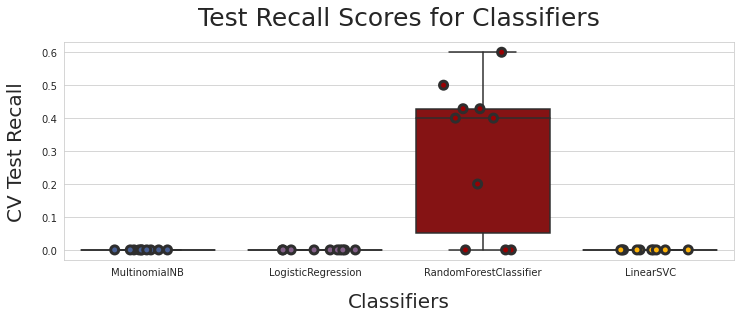

In [19]:
%%time
# generate 10 fold CV results for all models and plot performance measure of interest
get_reports(X_train, y_train, models, cv=10)

It seems the Random Forest classifier is the only one that has a chance of success.  
Despite their ususal ability to pick up signal from text data, the other models were not able to fit the imbalanced data.  
To demonstrate the how unique the top authors are, I'll show the chances of randomly selecting each rank of author.

In [20]:
# calculate changes of randomly picking each author class
class_counts = y.value_counts()
n_authors = len(y)

bottom_chance = class_counts.loc['bottom'] / n_authors * 100
middle_chance = class_counts.loc['middle'] / n_authors * 100
top_chance = class_counts.loc['top'] / n_authors * 100

print('Here are the chances of correctly classifying each rank, through random guessing:')
print('\n'f'Bottom Author: {bottom_chance:.3f}% chance')
print(f'Middle Author: {middle_chance:.3f}% chance')
print(f'Top Author: {top_chance:.3f}% chance ')

Here are the chances of correctly classifying each rank, through random guessing:

Bottom Author: 96.443% chance
Middle Author: 3.487% chance
Top Author: 0.070% chance 


The Randon Forest correctly classified 18 out of 51 top authors.  
Given that there are over 85,000 authors, a recall score of 0.353 is a good start for a base model.  
While over-sampling of the top class may improve the other models, I'm going to optimize the Random Forest, instead.

I'll save this DataFrame for the Random Forest optimization notebook.

In [21]:
# recall DataFrame being exported
df

,rank,titles,tokens,docs
author,,,,
maxwellhill,top,['Chinese Premier accuses Dalai Lama of master...,"[chinese, premier, accuse, dalai, lama, master...",chinese premier accuse dalai lama mastermind r...
anutensil,top,"['Top 10 discoveries of 2009', 'Mystery behind...","[discovery, mystery, make, stradivarius, speci...",discovery mystery make stradivarius special co...
Libertatea,top,['Life inside the Ecuadorian embassy with Wiki...,"[life, inside, ecuadorian, embassy, wikileaks,...",life inside ecuadorian embassy wikileaks found...
DoremusJessup,top,['Human Rights Watch claims $32 billion missin...,"[human, rights, watch, claim, billion, miss, a...",human rights watch claim billion miss angola a...
Wagamaga,top,['The government wants penalties including pot...,"[government, want, penalty, include, potential...",government want penalty include potential jail...
...,...,...,...,...
davitruiz,bottom,['Madrid train strike the day before holiday w...,"[madrid, train, strike, day, holiday, weekend,...",madrid train strike day holiday weekend ley mo...
davie18,bottom,['Remember that letter to Sainsbury s where a ...,"[remember, letter, sainsbury, little, girl, sa...",remember letter sainsbury little girl say tige...
davidstern350,bottom,['UOSSM Urges the International Organizations ...,"[uossm, urges, international, organizations, e...",uossm urges international organizations extend...


In [22]:
# store data in JSON file to avoid CSV complications
df.to_json('../data/author_docs.json')